# Simulation of fracture deformation by poro-mechanical effects
This notebook presents a model and simulation setup for fracture deformation in a poro-elastic medium. Fracture deformation here means relative movement of the fracture walls in the normal and / or tangential direction.

The model can be thought of as consisting of three components:
1. Poro-mechanical flow and deformation in the host rock. This is modeled by Biot's equations for poro-elasticity, which is based on balance of mass and momentuum.
2. Flow in fractures (and fracture intersections). This is the standard model for mixed-dimensional flow, based on conservation of mass.

Together these two components give forces on the fracture surface; it is important to realize that the fluid pressure here plays a dual role of a driving force for flow, and as a force is the momentuum balance equation. The force on the fracture surface can be decomposed into a tangential and normal component. If the tangential forces are sufficiently strong to overcome the frictional resistance, defined as the normal force times a friction coefficient, the fracture may slide. 

## Mathematical model
For the host rock domain $\Omega_i$, our primary variables are the displacment vector $u_i$ and the fluid pressure $p_i$. Further let $C_i$ be the stiffness matrix, $\phi_i$ porosity, $c$ the fluid compressibility, $K_i$ the matrix permeability, and let $b_i$ and $f_i$ be body forces and volumentric sources, respectively. Moreover, $I$ denotes the identity tensor, while $\alpha$ is Biot's cofficient, which can be interpreted as the fraction of a volume change, due to solid deformation, which is absorbed by the void space (and not the solid skeleton).
Biot's equations for momentum and mass balance then read,


$$ \begin{eqnarray} \nabla\cdot(C_i\nabla u_i - \alpha p_i I) & = & b_i \\ \alpha \frac{\partial(\nabla\cdot u_i)}{\partial t} + c\phi_i \frac{\partial p_i}{\partial t} - \nabla\cdot (K_i\nabla p_i) & = & f_i\end{eqnarray} $$

Next, consider an interface $\Gamma_j$ between the high-dimensional subdomain $\Omega_h$ and the lower-dimensional domain $\Omega_l$. The deformation variable on $\Gamma_j$ is denoted $u_j$. Continuity between $u_j$ and $tr u_h$ gives 

$$ \Pi_i^j tr(u_h) = u_j$$

where we have used the projection operator $\Pi_i^j$ between the boundary of $\Omega_h$ and $\Gamma_j$. Furthermore, let $[[u_j]]$ denote the displacement jump between the two interfaces on opposing sides of $\Omega_l$; we can decompose the jump into the normal part $[[u_j]]_n$ and the tangential part $[[u_j]]_{\tau}$. With this, mass conservation in the fracture is represented by 

$$ \frac{\partial [[u_j]]_n}{\partial t} + c \frac{\partial p_l}{\partial t} - \nabla\cdot (K_l\nabla p_l) = f_l $$

The mass flux over interface $\Gamma_j$ is given, as before, by 

$$ \lambda_j = \kappa_j (\Pi_h^j tr p_h - \Pi_l^j p_l)$$

Finally, we come to the model for the fracture deformation. This utilize a contact force $\sigma_l$, again decomposed into a normal part $\sigma_{l, n}$ and a tangential part $\sigma_{l, \tau}$. Force balance on $\Gamma_j$ between the poro-elastic stress in $\Omega_h$ and hte stress in $\Omega_l$ is expressed as

$$ \Pi_h^j n \cdot (\sigma_h - \alpha p_h I) = \Pi_l^j (\sigma_l - \gamma p_l n) $$

Where $n$ is the normal vector and $\gamma$ is a coefficient. In the direction normal to $\Omega_l$, the contact stress is zero only when the displacement jump is nonzero, that is

$$ [[u_j]]_n \leq 0, \qquad \sigma_{l,n} \leq 0, \qquad [[u_j]]_n \sigma_{l, r} = 0$$

The motion in hte tangential dricetion is contloled by the ratio between the tangential force $\sigma_{l,\tau}$ and the maximum available frictional force $F\sigma_{l,n}$, where $F$ is the friction coefficient. The displacement jump is zero until the frictional force is overcome; for langer tangential forces, displacement jump and tangential forces are parallel:

 \begin{cases} ||\sigma_{l,\tau}|| \leq F |\sigma_{l,n}| \\
 ||\sigma_{l,\tau}|| < F |\sigma_{l,n}| \implies ||\sigma_{l,\tau}|| =0 \\
 ||\sigma_{l,\tau}|| = F |\sigma_{l,n}| \implies  \exists\alpha\in R s.t. \sigma_{l,\tau}= -\alpha^2[[u_j]]_{\tau}
 \end{cases}

## Numerical methods
We will discretize the poro-elastic model in the higher-dimensional domain with a finite volume approach: The elasticity and the coupling terms are handled by the so-called multi-point stress approximation method, while the flow term is discretized with a multi-point flux approximation (mpfa). Finite volumes are also used for fracture flow. 

The discretization of the friction law deserves some extra attention: First, we note that the model is non-linear and indeed discontinuous, in that which equation is assigned (opening, slip, stick) depends on the solution. This is solved by a semismooth Newton approach, which is equivalent to an active set method.


# Simulation model
With that lengthy introduction, we can start developming a simulation model. As should be clear from the above presentation, the definition of variables, coulpings and discretizations can be overwhelming. Again, this is partly caused by the modularization of disretization inside PorePy, but mainly it reflects the complexity of the model equations themselves. Fortunately, for this specific problem, it is possible to use, or modify, a model class, as illustrated below.

In [1]:
# Imports. First the standard stuff
import numpy as np
import scipy.sparse as sps
from scipy.spatial.distance import cdist

from IPython.display import Image

import porepy as pp

# Also import the standardized model for poro-elastic contact problems. We will modify this model below.
import porepy.models.contact_mechanics_biot_model as model

c:\users\keile\dropbox\workspace\python\ppdir\src\porepy\grids\partition.py:19: UserWarning: Could not import pymetis. Some functions will not work as    intended
  intended"


In [2]:
class BiotSetup(model.ContactMechanicsBiot):
    
    def __init__(self, mesh_args, folder_name):
        """ Set arguments for mesh size (as explained in other tutorials)
        and the name fo the export folder.
        """
        super().__init__(mesh_args, folder_name)
        
        # File names for export
        self.file_name = "biot"
        
        # Fix names used for the variables:
        # Names for mechanics variables are set in a super class
        self.scalar_variable = "p"
        self.mortar_scalar_variable = "mortar_" + self.scalar_variable
        
        self.scalar_coupling_term = "robin_" + self.scalar_variable
        self.scalar_parameter_key = "flow"

        self.subtract_fracture_pressure = True

        # Scaling coefficients
        # The use of this is not mature. Be careful!
        self.scalar_scale = 1e5
        self.length_scale = 100

        # Time 
        self.time = 0
        self.time_step = 1500 * pp.DAY # obs scales with length scale
        self.end_time = self.time_step * 6

        self.initial_aperture = 1e-3 #/ self.length_scale
        # Dirichlet boundary condition for pressure
        self.s_0 = 1 * pp.MEGA / self.scalar_scale
        self.set_rock_and_fluid()

    def create_grid(self):
        """ Define a fracture network and domain and create a GridBucket. 
        
        This setup has two fractures inside the unit cell.
        
        The method also calls a submethod which sets injection points in 
        one of the fractures.
        
        """
        
        # Domain definition
        self.box = {"xmin": 0, "ymin": 0, "xmax": 1, "ymax": 1}
        self.frac_pts = np.array([[0.2, 0.6, 0.4, 0.8],
                                  [0.5, 0.5, 0.6, 0.6]])
        frac_edges = np.array([[0, 2],
                               [1, 3]]) # Each column is one fracture

        network = pp.FractureNetwork2d(self.frac_pts, frac_edges, domain=self.box)
        # Generate the mixed-dimensional mesh
        gb = network.mesh(self.mesh_args)

        pp.contact_conditions.set_projections(gb)

        self.gb = gb
        self.Nd = self.gb.dim_max()
        self.well_cells()

    def well_cells(self):
        """
        Assign unitary values to injection cells (positive) and production cells
        (negative).
        
        The wells are marked by g.tags['well_cells'], and in the data dictionary
        of this well.
        
        """
        for g, d in self.gb:
            tags = np.zeros(g.num_cells)
            if g.dim == self.Nd - 1:  # We should not ask for frac_num in intersections
                if g.frac_num == 4:
                    tags[1] = 1
            g.tags["well_cells"] = tags
            pp.set_state(d, {"well": tags.copy()})

    def faces_to_fix(self, g):
        """
        Identify Nd boundary faces to fix (u=0). This should allow us to assign
        Neumann "background stress" conditions on the rest of the boundary faces.
        """
        # Get all faces of g that are on the domain boundary.
        # Note that for an immersed fracture, this would be none
        # (even though the fracture itself will have boundaries)
        all_bf, *_ = self.domain_boundary_sides(g)
        # Point on the middle of the boundary faces y=y_min
        point = np.array([[(self.box["xmin"] + self.box["xmax"])/2],
                          [self.box["ymin"]],
                          [0]])
        # Distance from boundary faces to this point
        distances = pp.distances.point_pointset(point, g.face_centers[:, all_bf])
        indexes = np.argsort(distances)
        # Find the first Nd fractures, return their indices
        faces = all_bf[indexes[:self.Nd]]
        return faces

    def bc_type_mechanics(self, g):
        """ Get the type of boundary conditions for the mechanics.
        
        Returns: 
            BoundaryConditionVectorial - representation of boundary conditions.
        """
        # Get faces on the global boundary
        all_bf, *_ = self.domain_boundary_sides(g)
        # Find faces to fix. Neumann conditions will be set there
        faces = self.faces_to_fix(g)
        # Set Dirichlet conditions on fixed faces - the rest will implicitly be assigned Neumann conditions.
        bc = pp.BoundaryConditionVectorial(g, faces, "dir")
        # Faces that neighbor a fracture. These will be internal boundaries, and assigned a Direchlet condition.
        frac_face = g.tags["fracture_faces"]
        bc.is_neu[:, frac_face] = False
        bc.is_dir[:, frac_face] = True
        return bc

    def bc_type_scalar(self, g):
        """ Get the type of boundary conditions for the flow problem.
        
        Set Dirichlet conditions on all global boundary faces.
        
        Returns:
            BoundaryCondition: Representation of boundary conditions.
        """
        all_bf, east, west, north, south, top, bottom = self.domain_boundary_sides(g)
        return pp.BoundaryCondition(g, all_bf, "dir")

    def bc_values_mechanics(self, g):
        """ Get values for the mechanics boundary conditions.
        """
        
        # Retrieve the boundaries where values are assigned
        all_bf, east, west, north, south, top, bottom = self.domain_boundary_sides(g)
        # Set the boundary values
        
        # Stress densities - should be scaled with areas
        normal_traction = 3 * pp.MEGA * pp.PASCAL / self.scalar_scale
        A = g.face_areas
        bc_values = np.zeros((g.dim, g.num_faces))
        # Set an anisotropic bacground stress.
        # This will give strong tangential forces on some fracture faces, thus slip.
        bc_values[0, west] = 0.8 * normal_traction * A[west]
        bc_values[0, east] = - 0.8 * normal_traction * A[east]
        bc_values[1, south] = 1.2 * normal_traction * A[south]
        bc_values[1, north] = -1.2 * normal_traction * A[north]
        if self.Nd > 2:
            bc_values[2, bottom] = 1.0 * normal_traction * A[bottom]
            bc_values[2, top] = - 1.0 * normal_traction * A[top]

        # Fix the Dirichlet faces
        faces = self.faces_to_fix(g)
        bc_values[:, faces] = 0

        return bc_values.ravel("F")

    def bc_values_scalar(self, g):
        # Retrieve the boundaries where values are assigned
        all_bf, east, west, north, south, top, bottom = self.domain_boundary_sides(g)
        bc_values = np.zeros(g.num_faces)
        
        # Set equal boundary condition for the pressure
        bc_values[all_bf] = self.s_0
        return bc_values

    def source_scalar(self, g):
        """
        Positive well tags are injection cells.
        
        The source term is already scaled with time step.
        """
        values = np.zeros(g.num_cells)
        if self.time > 1e-10:
            flow_rate = 0.001 * pp.MILLI * (pp.METER / self.length_scale) ** self.Nd
            values = flow_rate * g.tags["well_cells"]* self.time_step
        return values
    
    def source_mechanics(self, g):
        """ No body forces.
        
        """
        return np.zeros(g.num_cells * self.Nd)
        

    def compute_aperture(self, g):
        apertures = np.ones(g.num_cells)
        if g.dim == (self.Nd - 1):
            # Initial aperture
            apertures *= self.initial_aperture
            # Only if the displacements are to be accounted for:
#            # Reconstruct the displacement solution on the fracture
#            g_h = self.gb.node_neighbors(g)[0]
#            assert g_h.dim == Nd
#            data_edge = self.gb.edge_props((g, g_h))
#            if pp.STATE in data_edge:
#                u_mortar_local = self.reconstruct_local_displacement_jump(data_edge)
#                # Magnitudes of normal and tangential components
#                norm_u_n = np.linalg.norm(u_mortar_local[-1], axis=0)
#                norm_u_tau = np.linalg.norm(u_mortar_local[:-1], axis=0)
#                # Add contributions
#                slip_angle = 0.5
#                apertures += norm_u_n * np.cos(slip_angle) + norm_u_tau
#            else:
#                print(
#                    "found no displacement solution. Computing aperture from initial value"
#                )
        return apertures

    def set_permeability_from_aperture(self):
        """
        Cubic law in fractures, rock permeability in the matrix.
        """
        viscosity = self.fluid.dynamic_viscosity() / self.scalar_scale
        gb = self.gb
        for g, d in gb:
            if g.dim < self.Nd:
                # Use cubic law in fractures
                apertures = self.compute_aperture(g)
                apertures_unscaled = apertures * self.length_scale
                k = np.power(apertures_unscaled, 2) / 12
                kxx = k / viscosity / self.length_scale ** 2
            else:
                # Use the rock permeability in the matrix
                kxx = (
                    self.rock.PERMEABILITY
                    / viscosity
                    * np.ones(g.num_cells)
                    / self.length_scale ** 2
                )

            K = pp.SecondOrderTensor(3, kxx)
            d[pp.PARAMETERS][self.scalar_parameter_key]["second_order_tensor"] = K

        # Normal permeability inherited from fracture
        for e, d in gb.edges():
            mg = d["mortar_grid"]
            g_s, g_m = gb.nodes_of_edge(e)
            data_s = gb.node_props(g_s)
            a = self.compute_aperture(g_s)
            # We assume isotropic permeability in the fracture
            k_s = data_s[pp.PARAMETERS][self.scalar_parameter_key][
                "second_order_tensor"
            ].values[0, 0]
            kn = 2 * mg.slave_to_mortar_int() * np.divide(k_s, a)
            pp.initialize_data(mg, d, self.scalar_parameter_key, {"normal_diffusivity": kn})

    def set_rock_and_fluid(self):
        """
        Set rock and fluid properties to granite and water.
        """
        self.rock = pp.Granite()
        self.rock.FRICTION_COEFFICIENT = 0.5
        self.fluid = pp.Water()
        self.rock.PERMEABILITY = 1e-16

    def biot_alpha(self):
        return 0.8

    def set_mechanics_parameters(self):
        gb = self.gb
        for g, d in gb:
            if g.dim == self.Nd:
                # Rock parameters
                rock = self.rock
                lam = (
                    rock.LAMBDA * np.ones(g.num_cells) / self.scalar_scale
                )
                mu = (
                    rock.MU * np.ones(g.num_cells) / self.scalar_scale
                )

                C = pp.FourthOrderTensor(g.dim, mu, lam)
                bc = self.bc_type_mechanics(g)

                bc_values = self.bc_values_mechanics(g)
                sources = self.source_mechanics(g)
                pp.initialize_data(
                    g,
                    d,
                    self.mechanics_parameter_key,
                    {
                        "bc": bc,
                        "bc_values": bc_values,
                        "source": sources,
                        "fourth_order_tensor": C,
                        "biot_alpha": self.biot_alpha()
                    },
                )
                d[pp.PARAMETERS].set_from_other(
                    self.mechanics_parameter_key,
                    self.scalar_parameter_key,
                    ["aperture", "time_step"],
                )
            elif g.dim == self.Nd - 1:
                friction = self._set_friction_coefficient(g)
                pp.initialize_data(
                    g,
                    d,
                    self.mechanics_parameter_key,
                    {"friction_coefficient": friction},
                )
                pp.initialize_data(g, d, self.mechanics_parameter_key, {})

        for e, d in gb.edges():
            mg = d["mortar_grid"]
            # Parameters for the surface diffusion. No clue about values
            mu = self.rock.MU
            lmbda = self.rock.LAMBDA
            pp.initialize_data(
                mg, d, self.mechanics_parameter_key, {"mu": mu, "lambda": lmbda}
            )

    def set_scalar_parameters(self):
         # * self.scalar_scale
        for g, d in self.gb:
            # Aperture [m] and cross sectional area [m**(self.Nd - g.dim)]
            a = self.compute_aperture(g)
            cross_sectional_area = np.power(a, self.gb.dim_max() - g.dim) * np.ones(
                g.num_cells
            )
            # Define boundary conditions for flow
            bc = self.bc_type_scalar(g)

            # Set boundary condition values
            bc_val = self.bc_values_scalar(g)

            # and source values
            sources = self.source_scalar(g)
            alpha = self.biot_alpha()

            # Add fluid flow dictionary
            pp.initialize_data(
                g,
                d,
                self.scalar_parameter_key,
                {
                    "bc": bc,
                    "bc_values": bc_val,
                    "mass_weight": self.fluid.COMPRESSIBILITY,
                    "aperture": cross_sectional_area,
                    "time_step": self.time_step,
                    "source": sources,
                    "biot_alpha": alpha,
                },
            )
        for _, d in self.gb.edges():
            mg = d["mortar_grid"]
            pp.initialize_data(mg, d, self.scalar_parameter_key)
        self.set_permeability_from_aperture()


    def initial_condition(self, time=0):
        """
        Initial guess for Newton iteration.
        """
        gb = self.gb
        key_m = self.mechanics_parameter_key

        for g, d in gb:
            nc_nd = g.num_cells * self.Nd
            # Initial value for the scalar variable.
            initial_scalar_value = self.s_0 * np.ones(g.num_cells)

            if g.dim == self.Nd:
                if self.time < 1e-10:
                    initial_displacements = np.zeros(nc_nd)
                else:
                    initial_displacements = d["initial_cell_displacements"]
                # Initialize displacement variable
                state = {
                    self.displacement_variable: initial_displacements,
                    self.scalar_variable: initial_scalar_value,
                    key_m: {"bc_values": d[pp.PARAMETERS][key_m]["bc_values"]},
                }
            elif g.dim == self.Nd - 1:
                # Initialize contact variable
                traction = np.vstack(
                    (
                        np.zeros((self.Nd - 1, g.num_cells)),
                        -100 * np.ones(g.num_cells),
                    )
                ).ravel(order="F")
                state = {
                        "previous_iterate": {self.contact_traction_variable: traction},
                        self.scalar_variable: initial_scalar_value,
                        }
            pp.set_state(d, state)

        for e, d in gb.edges():
            mg = d["mortar_grid"]
            if self.time < 1e-10:
                initial_displacements = np.zeros(mg.num_cells * self.Nd)
            else:
                initial_displacements = d["initial_cell_displacements"]
            if mg.dim == self.Nd - 1:
                state = {
                    self.mortar_displacement_variable: initial_displacements,
                    "previous_iterate": {
                        self.mortar_displacement_variable: initial_displacements
                    },
                }
                pp.set_state(d, state)

    def _set_friction_coefficient(self, g):
        nodes = g.nodes
        tips = nodes[:, [0, -1]]
        fc = g.cell_centers
        D = cdist(fc.T, tips.T)
        D = np.min(D, axis=1)
        R = 200
        beta = 10
        friction_coefficient = self.rock.FRICTION_COEFFICIENT * (1 + beta * np.exp(-R * D ** 2))
        return friction_coefficient

    def set_exporter(self):
        self.exporter = pp.Exporter(self.gb, self.file_name, folder=self.folder_name)
        self.export_fields = ["u_exp", "p_exp", "well"]
        self.export_times = []

    def export_step(self):
        if "exporter" not in self.__dict__:
            self.set_exporter()
        for g, d in self.gb:
            if g.dim == self.Nd:
                u = d[pp.STATE][self.displacement_variable].reshape(
                    (setup.Nd, -1), order="F"
                )
                if g.dim == 3:
                    d[pp.STATE]["u_exp"] = u * setup.length_scale
                else:
                    d[pp.STATE]["u_exp"] = np.vstack(
                        (u * setup.length_scale, np.zeros(u.shape[1]))
                    )
            else:
                g_h = self.gb.node_neighbors(g)[0]
                assert g_h.dim == self.Nd
                data_edge = self.gb.edge_props((g, g_h))
                u_mortar_local = self.reconstruct_local_displacement_jump(
                    data_edge,
                )
                if g.dim == 2:
                    d[pp.STATE]["u_exp"] = u_mortar_local * setup.length_scale
                else:
                    d[pp.STATE]["u_exp"] = np.vstack(
                        (
                            u_mortar_local * setup.length_scale,
                            np.zeros(u_mortar_local.shape[1]),
                        )
                    )
            d[pp.STATE]["p_exp"] = d[pp.STATE][self.scalar_variable] * self.scalar_scale
        self.exporter.write_vtk(self.export_fields, time_step=self.time)
        self.export_times.append(self.time)


    def export_pvd(self):
        self.exporter.write_pvd(np.array(self.export_times))


With the above class definition, we are mainly done with the complexity of the setup. What remains is to set the mesh size, and create a setup object that carries all parameters.

In [3]:
Nd = 2
mesh_size = 0.05
mesh_args = {
    "mesh_size_frac": mesh_size,
    "mesh_size_min": 0.1 * mesh_size,
    "mesh_size_bound": 3 * mesh_size,
}
folder_name = "biot_2d"
setup = BiotSetup(mesh_args, folder_name)

### Ininitialization
We will asusme that the domain initially is in equilibrium: 
* The fluid pressure is flat corresponding to zero injection,
* The stress and displacements on in the domain and on the fracture (really on the mortar grids adjacent to the fractures) correspond to the mechanics boundary conditions.

The simulation is ran by the run_biot() function in contact_mechanics_biot_model. This function carries out the following:

1. Create a GridBucket, unless the setup class already has a grid.
2. Set parameters, variables and discretization in the GridBucket. All relevant values are takne from the setup file.
3. Perform discretization as instructed in step 2. 
4. Run time stepping, export the result to paraview.


In [4]:
# Run simulation until a steady state is reached (this may require some trial and error, depending on the setup)
setup.file_name = "initialize_run"
model.run_biot(setup)

Time step:  1 / 6
Newton iteration number:  0 / 15
max A: 4.61e+11
max: 4.61e+11 and min: 5.07e-02 A sum: 
Error, solution norm and iterate_difference/solution_norm:  1.0 1.1203317064306815e-09 1.0
Newton iteration number:  1 / 15
max A: 4.61e+11
max: 4.61e+11 and min: 5.07e-02 A sum: 
Error, solution norm and iterate_difference/solution_norm:  0.0 1.1203317064306815e-09 0.0
Time step:  2 / 6
Newton iteration number:  0 / 15
max A: 4.61e+11
max: 4.61e+11 and min: 5.07e-02 A sum: 
Error, solution norm and iterate_difference/solution_norm:  2.7126171666918603e-07 1.1214312635316308e-09 2.7259614790714824e-07
Newton iteration number:  1 / 15
max A: 4.61e+11
max: 4.61e+11 and min: 5.07e-02 A sum: 
Error, solution norm and iterate_difference/solution_norm:  0.0 1.1214312635316308e-09 0.0
Time step:  3 / 6
Newton iteration number:  0 / 15
max A: 4.61e+11
max: 4.61e+11 and min: 5.07e-02 A sum: 
Error, solution norm and iterate_difference/solution_norm:  1.6564807514887275e-13 1.12143211335527

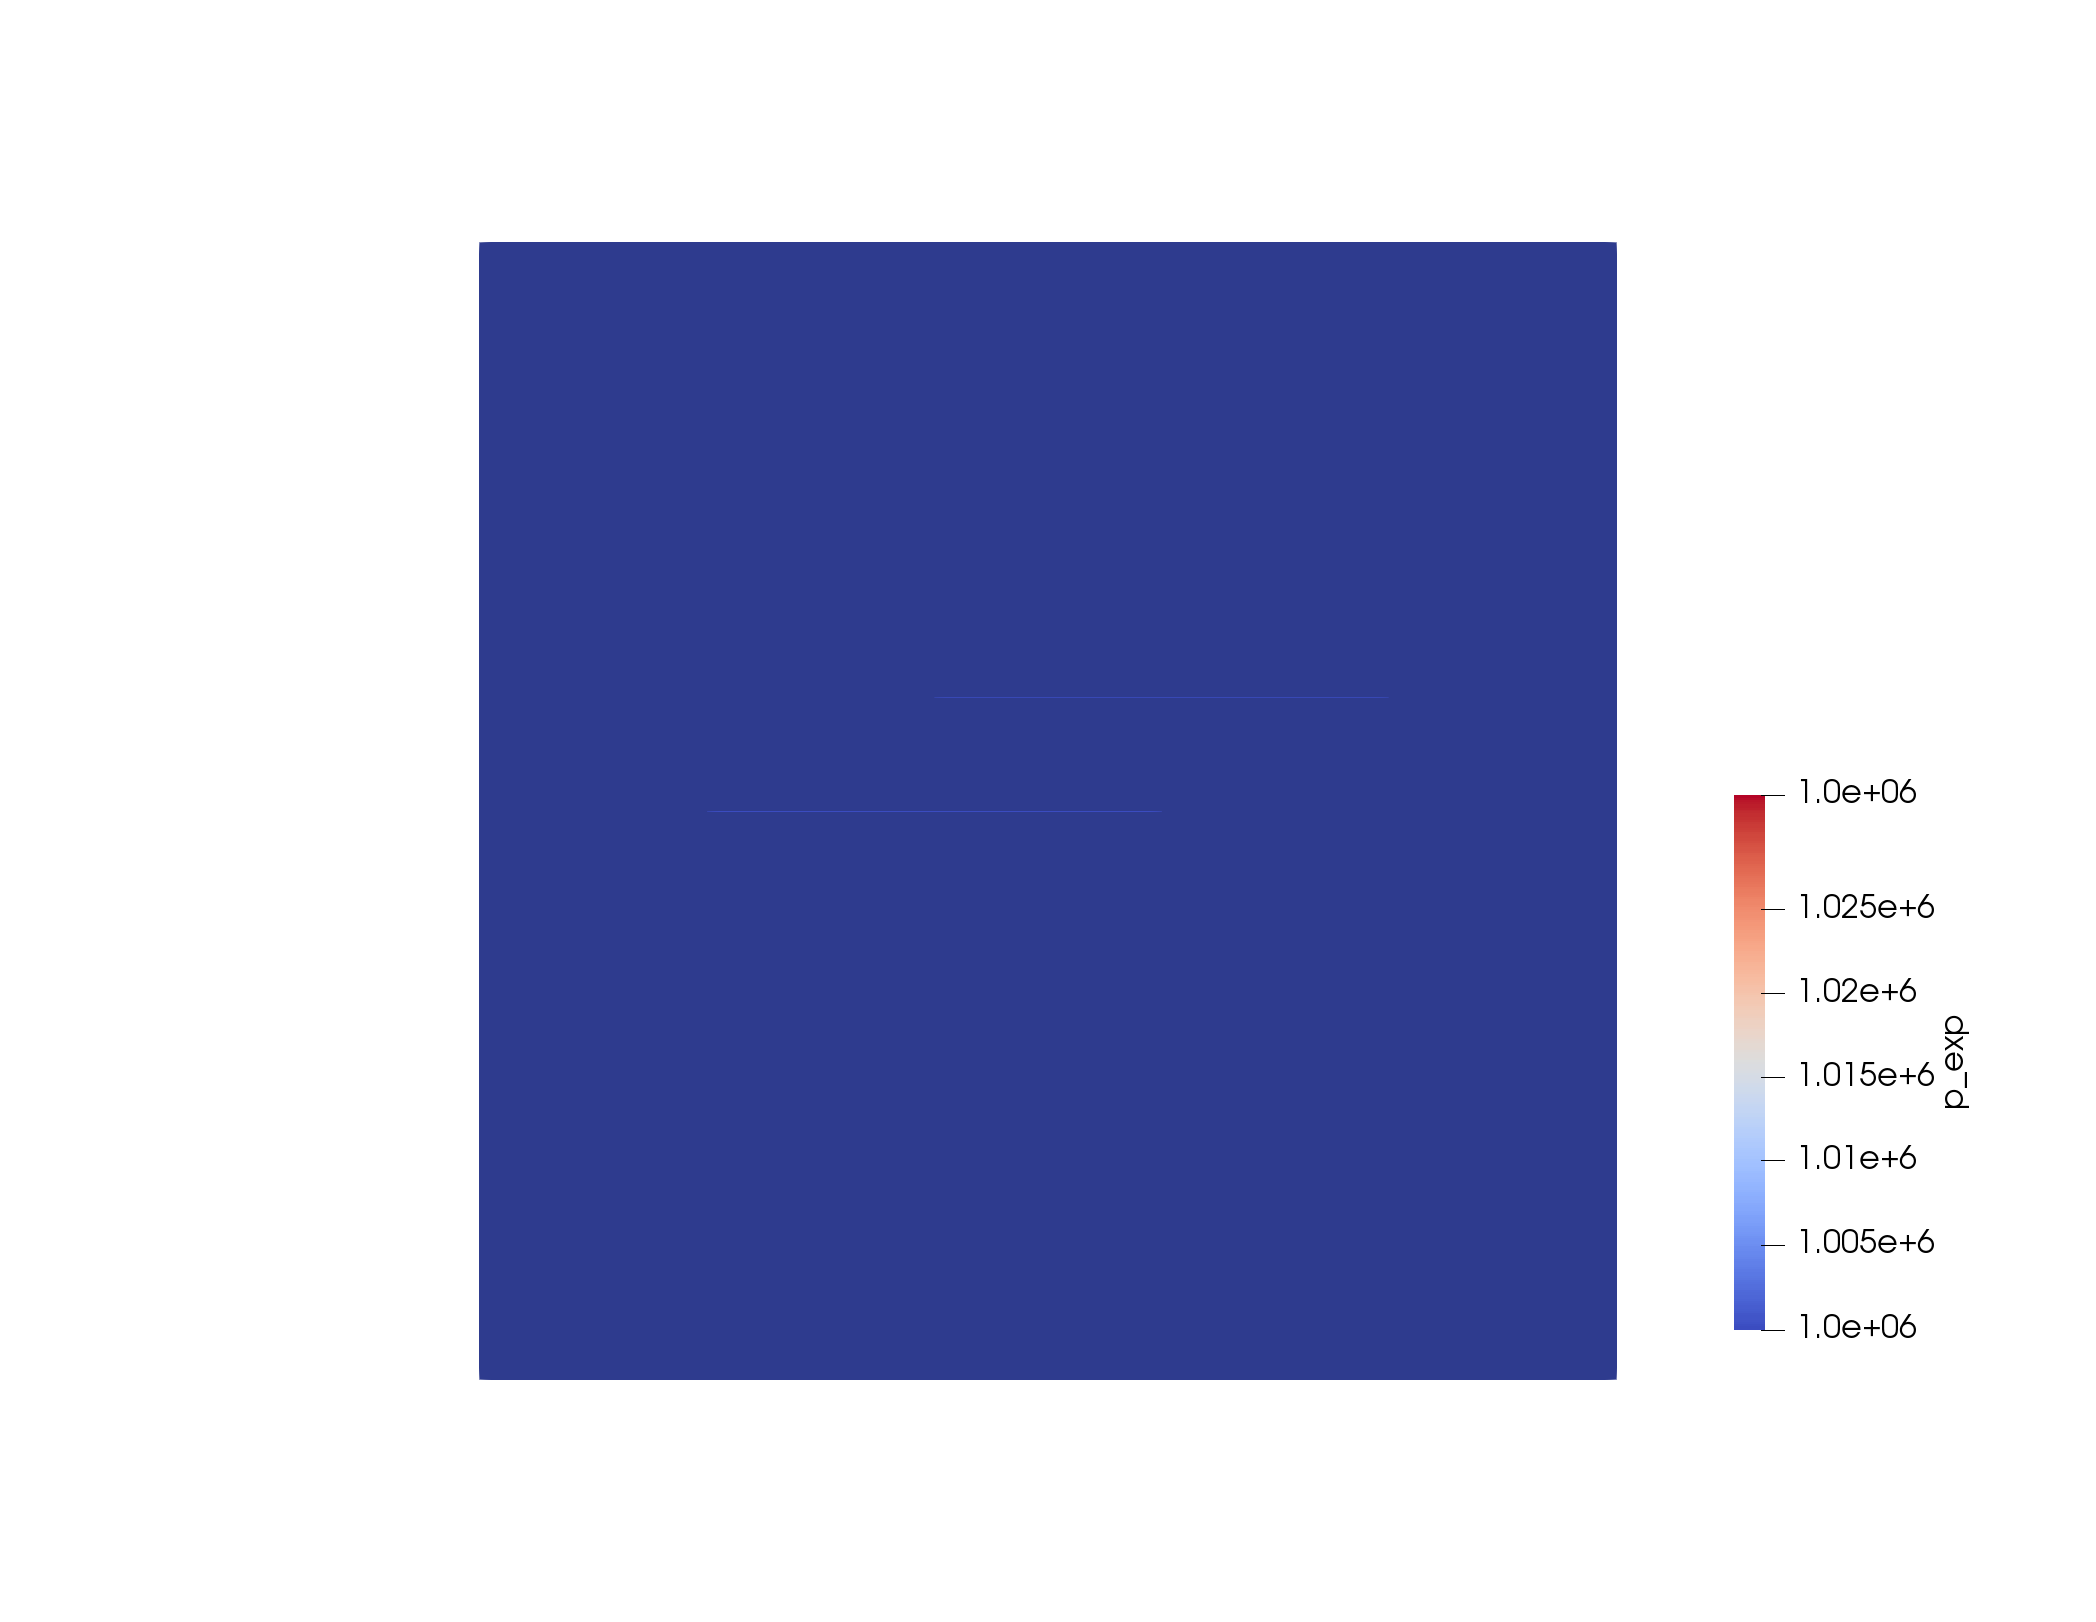

In [5]:
Image("img/biot_2d_p_initial.png")

As we see, the pressure is in equiliblrium. Next, the displacement field - the y-direction is shown

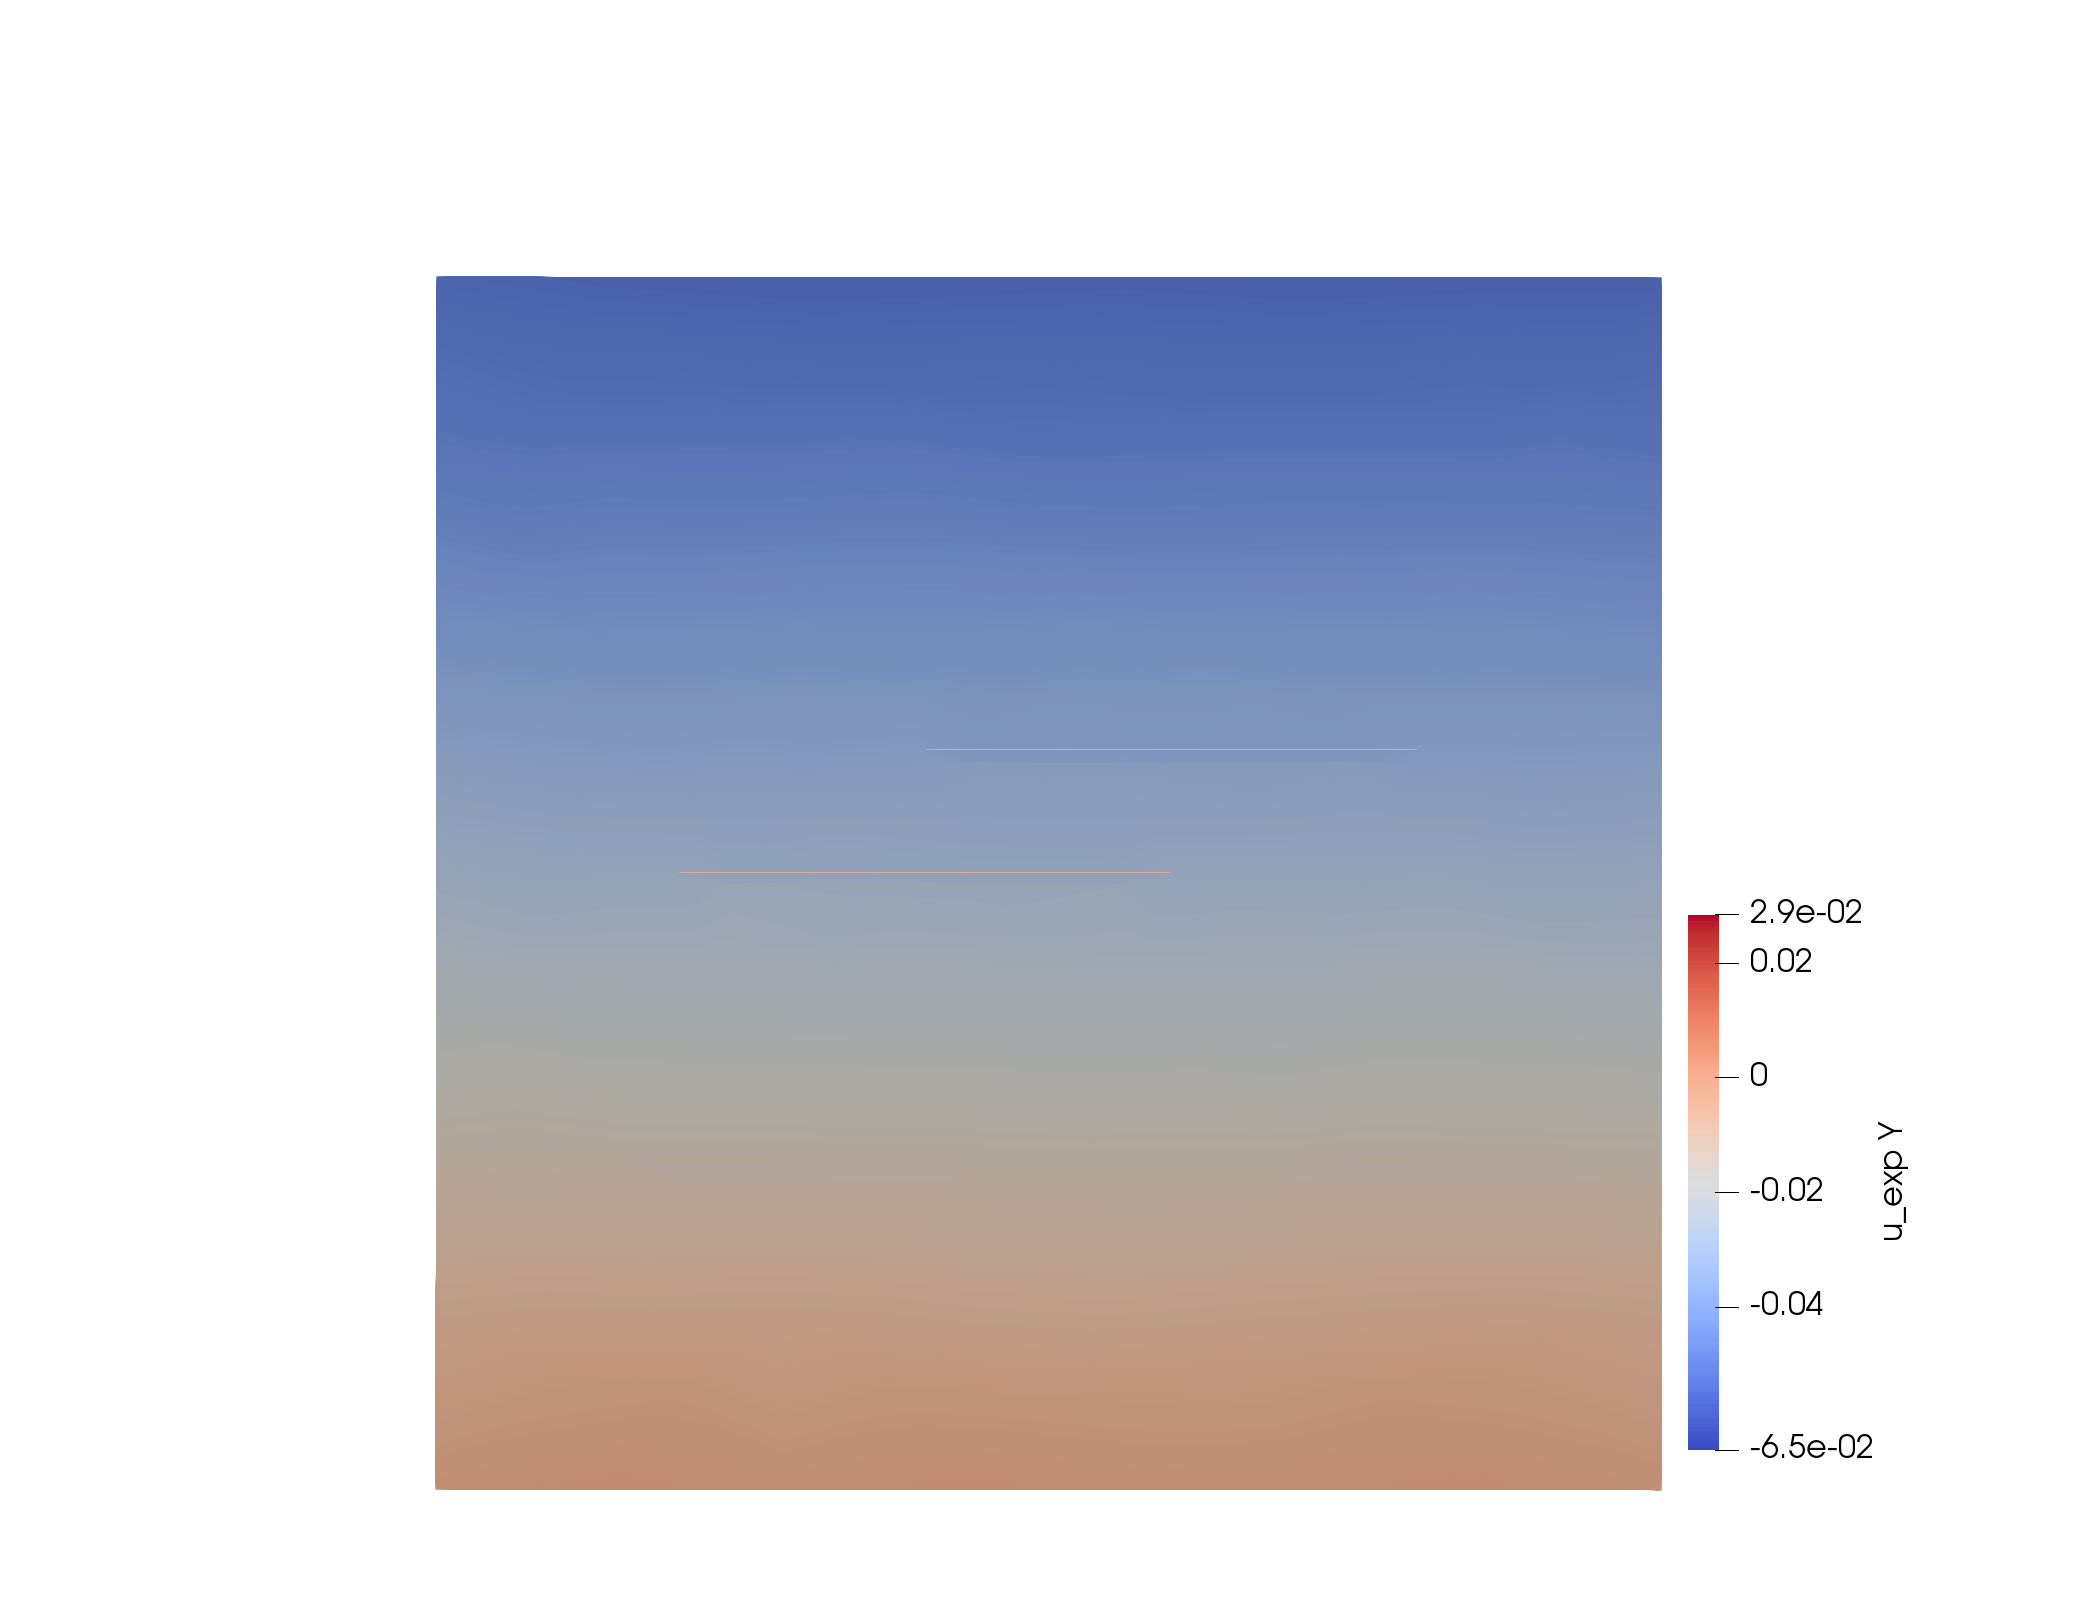

In [6]:
Image("img/biot_2d_uy_initial.png")


Shown is the displacement filed in the y-direction for the 2d domain, and the displacement jump over the fractures. The latter is zero - reflecting that the fracture is closed (recall that the stress boundaries push the top and bottom towards the middle of the domain).

### Fluid injection
Next, start injection in the lowermost fracture. We need only do a few minor adjustments of the model setup relative to how we did the initialization. 

Note also a trick, perhaps a dirty one, regarding activation of the source term: The equations are mainly linear - the only non-linear terms relate to the contact mechanics. Most terms, hereunder the source term, is discretized only at the start of the simulations. This is exploited in the function BiotSetup.source_scalar(), which sets the source to zero on injection depending on whehter the time is larger than zero. 

In [7]:
setup.file_name = "main_run"

# increase time somewhat above 0 - this will make the source term being assembled to injection.
setup.time = 1e-5

# Reset the exporter with a new file name.
setup.set_exporter()
setup.end_time *= 2

# Transfer the steady states computed initialization to initial guess for the injection phase.
for g, d in setup.gb:
    if g.dim == Nd:
        u = d[pp.STATE][setup.displacement_variable]
        d["initial_cell_displacements"] = u

for e, d in setup.gb.edges():
    u = d[pp.STATE][setup.mortar_displacement_variable]
    d["initial_cell_displacements"] = u

# Run the simulation with this setup
model.run_biot(setup)

Time step:  1 / 12
Newton iteration number:  0 / 15
max A: 4.61e+11
max: 4.61e+11 and min: 5.07e-02 A sum: 
Error, solution norm and iterate_difference/solution_norm:  0.04452082463229093 8.180507567126562e-10 0.04463123605803535
Newton iteration number:  1 / 15
max A: 4.61e+11
max: 4.61e+11 and min: 5.07e-02 A sum: 
Error, solution norm and iterate_difference/solution_norm:  2.105681873148876 3.2754231434237323e-10 2.2716028814838647
Newton iteration number:  2 / 15


c:\users\keile\dropbox\workspace\python\ppdir\src\porepy\numerics\contact_mechanics\contact_conditions.py:374: RuntimeWarning: invalid value encountered in true_divide
  alpha = -Tt.T.dot(-Tt + cut) / (self._l2(-Tt) * self._l2(-Tt + cut))
c:\users\keile\dropbox\workspace\python\ppdir\src\porepy\numerics\contact_mechanics\contact_conditions.py:377: RuntimeWarning: invalid value encountered in less
  if alpha < 0:


max A: 4.61e+11
max: 4.61e+11 and min: 5.07e-02 A sum: 
Error, solution norm and iterate_difference/solution_norm:  0.3502211426318392 6.767059099232006e-10 0.3177957008715453
Newton iteration number:  3 / 15
max A: 4.61e+11
max: 4.61e+11 and min: 5.07e-02 A sum: 
Error, solution norm and iterate_difference/solution_norm:  0.23162353503530275 3.8880343282149613e-10 0.24984677820183512
Newton iteration number:  4 / 15
max A: 4.61e+11
max: 4.61e+11 and min: 5.07e-02 A sum: 
Error, solution norm and iterate_difference/solution_norm:  0.013777101932337594 3.5001930059355403e-10 0.015032363499478708
Newton iteration number:  5 / 15
max A: 4.61e+11
max: 4.61e+11 and min: 5.07e-02 A sum: 
Error, solution norm and iterate_difference/solution_norm:  0.005069396166822729 3.3135077697924415e-10 0.005840027094388988
Newton iteration number:  6 / 15
max A: 4.61e+11
max: 4.61e+11 and min: 5.07e-02 A sum: 
Error, solution norm and iterate_difference/solution_norm:  1.367905393690908e-05 3.30462649376

Finally we visualize the results: The pressure field

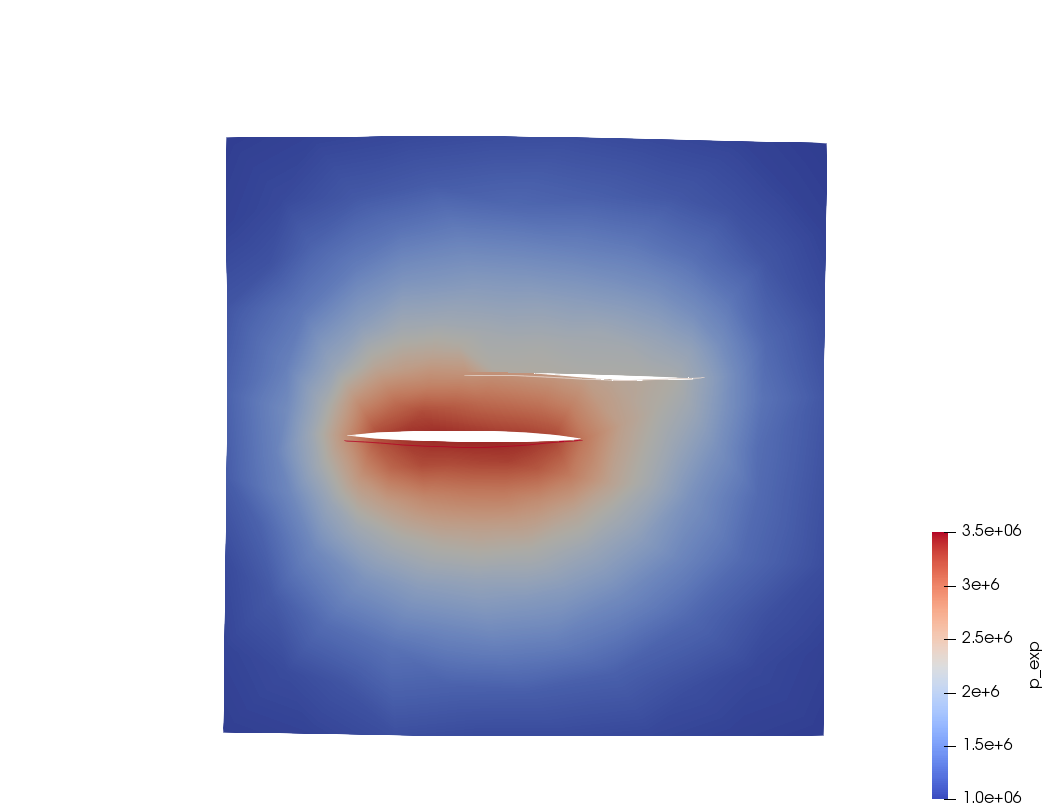

In [8]:
Image('img/biot_2d_p_final.png')

The geometry is shown in the deformed configuration, inculding fracture opening. The 1d representation of the fractures are not deformed in the visualization, hence slightly odd white and blue lines.

The displacement in the y-direction is given below:

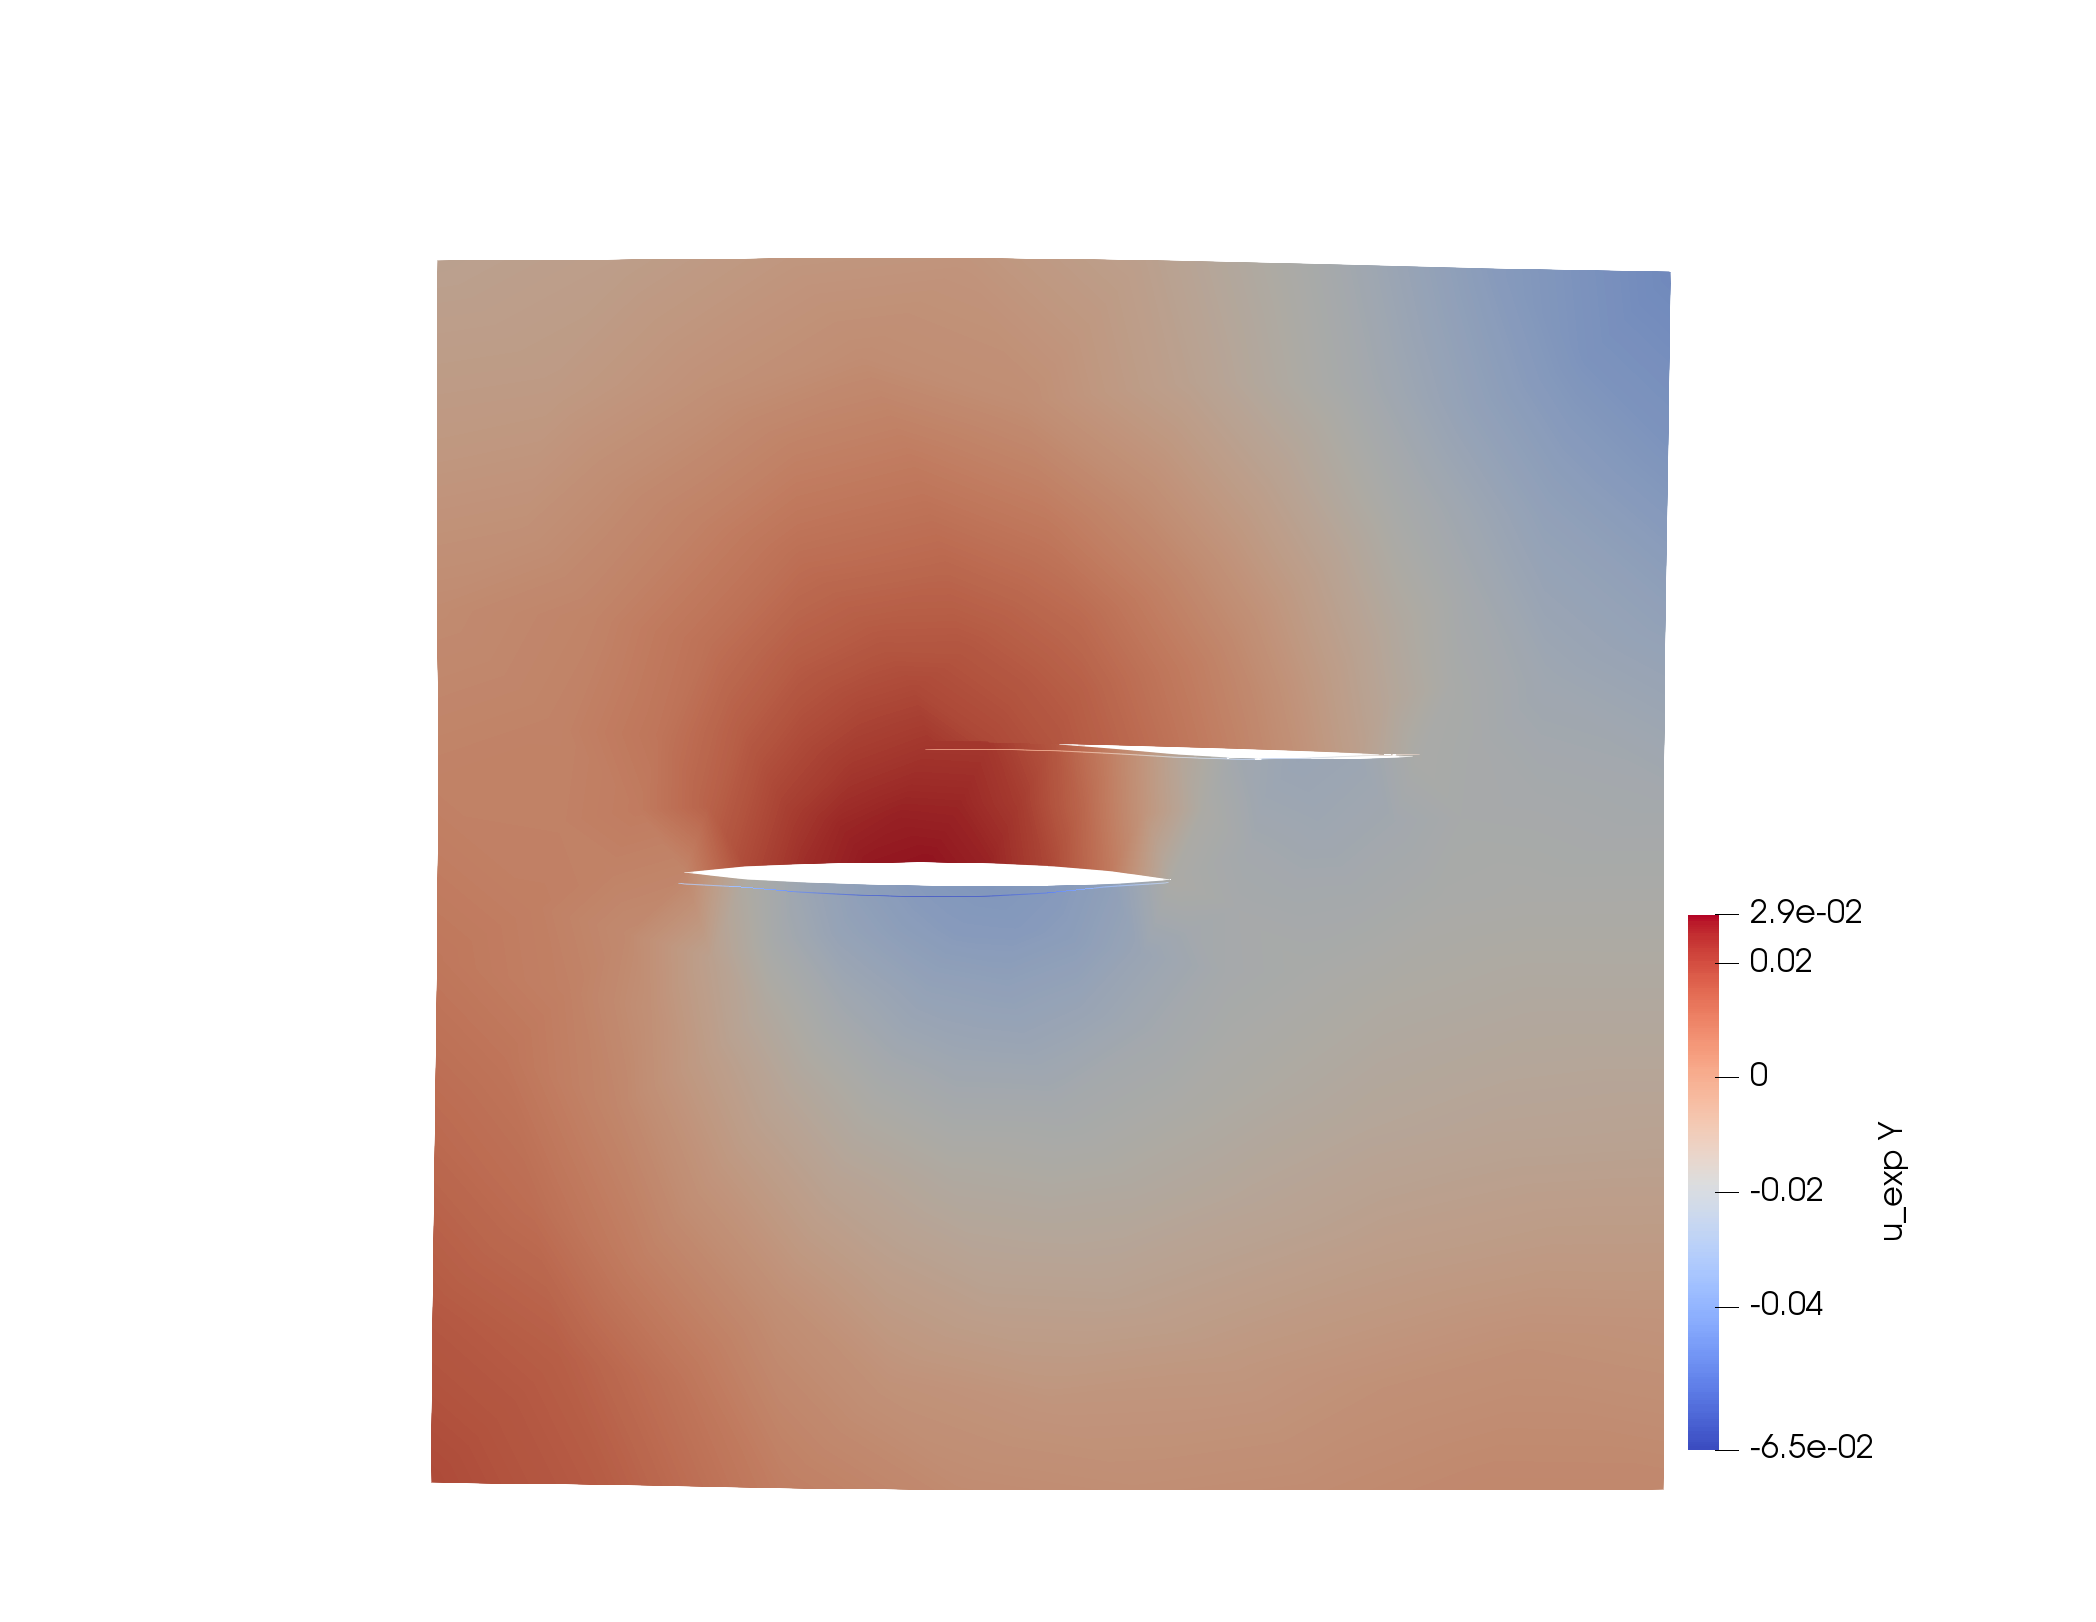

In [9]:
Image("img/biot_2d_uy_final.png")

.. and the displacement jump along the fracutres. First the y-direction

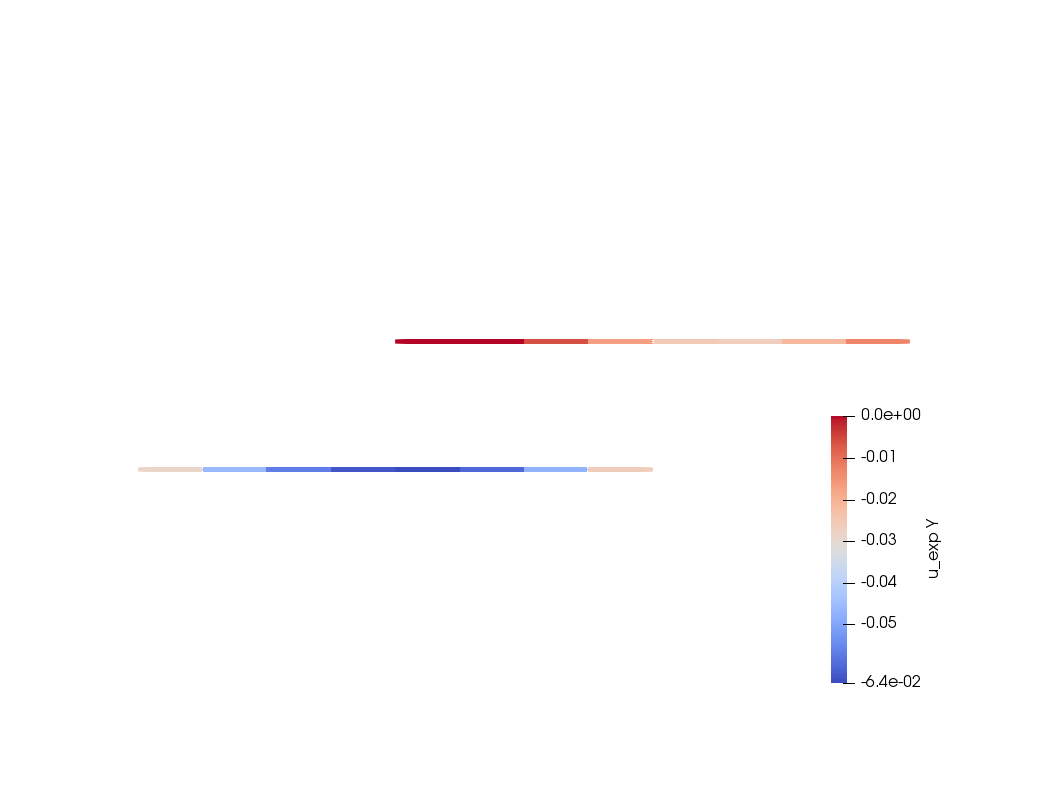

In [10]:
Image("img/biot_2d_opening_y_final.png")

Note how the left part of the uppermost fracture stays closed due to the stress from the opening of the lower fractures (where injection takes place).

Finally, displacement jumps in the x-direction

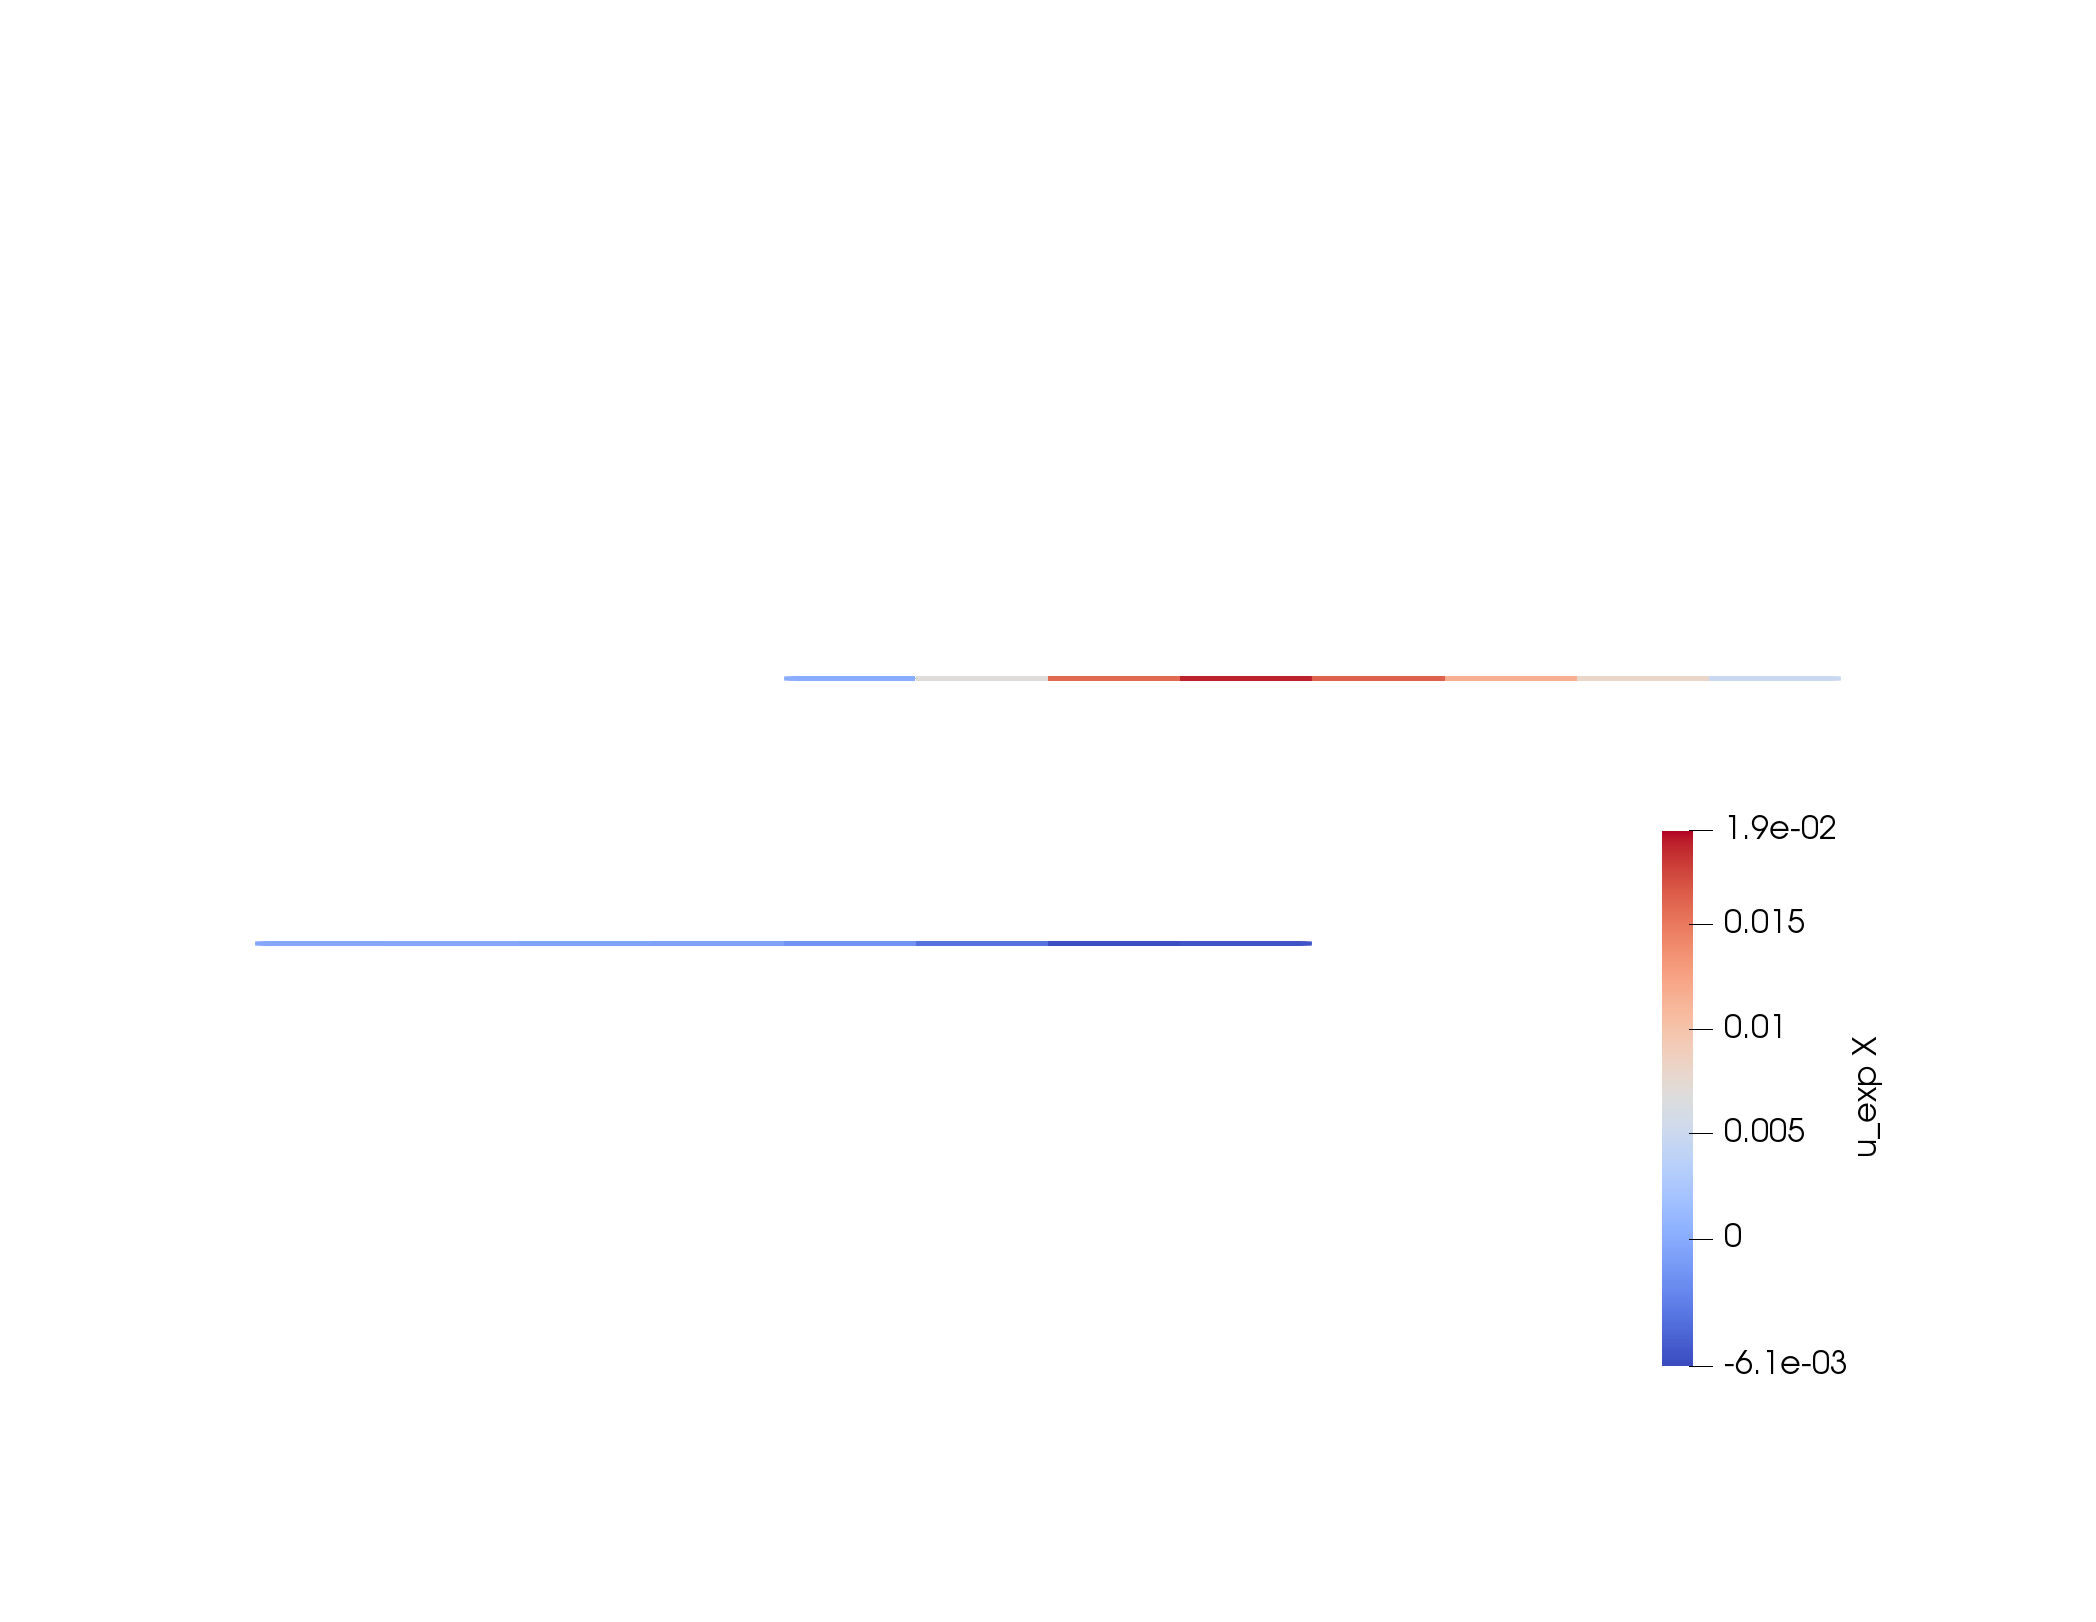

In [11]:
Image("img/biot_2d_slip_x_accumulated.png")